# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
# Unity ml-agents path
import sys
sys.path.append("../python/")

In [3]:
from unityagents import UnityEnvironment
import numpy as np

In [4]:
env = UnityEnvironment(file_name="../Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
###### from maddpg_agent import *

import matplotlib.pyplot as plt
%matplotlib inline
import time

def train(n_episodes=500, max_t=1000, random_seed=1, agent=None, debug=False):

    agents = [Agent(state_size=state_size, action_size=action_size, 
                      random_seed=random_seed, 
                   num_agents=num_agents) for i in range(num_agents)]
       
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_plot = []
    scores_ave = []
    scores_agent = []
   
    for i_episode in range(1, n_episodes + 1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = np.reshape(env_info.vector_observations, (1,num_agents*state_size))
        scores = np.zeros(num_agents)
        for agent in agents:
            agent.reset()

        time_start = time.time()
        
        for _ in range(max_t):
            actions = [agent.act(states, True) for agent in agents]
            actions = np.concatenate(actions, axis=0).flatten()
            env_info = env.step(actions)[brain_name]
            next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size))
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done  # see if episode has finished
            for i, agent in enumerate(agents):
                agent.step(states, actions, rewards[i], next_states, dones[i], i)

            states = next_states
            scores += rewards
                            
            if np.any(dones):
                break
            
        duration = time.time() - time_start
        
        scores_window.append(np.mean(scores))  # save most recent score
        scores_plot.append(np.mean(scores))
        scores_ave.append(np.mean(scores_window))
        scores_agent.append(scores)
                
        print('\rEpisode {}({}sec)\t MIN:{:.2f} MAX:{:.2f} MEAN:{:.2f} MEANo100:{:.2f} {}'.format(i_episode, 
                                    round(duration), np.min(scores), 
                                     np.max(scores), np.mean(scores), 
                                     np.mean(scores_window), ' '*10), end='')
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))            
            # plot the scores
            fig, ax = plt.subplots()
            
            plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
            for i in range(num_agents):
                plt.plot(np.arange(len(np.vstack(scores_agent))), 
                         np.vstack(scores_agent)[:,i], label='Agent {}'.format(i+1))
            plt.plot(np.arange(len(scores_plot)), scores_plot, label='Score Ave')
            plt.xlabel('Episode #')
            ax.legend()
            plt.show()
                        
            for i in range(num_agents):
                torch.save(agents[i].actor_local.state_dict(), 'actor{}_{}.pth'.format(i, i_episode))
                torch.save(agents[i].critic_local.state_dict(), 'critic{}_{}.pth'.format(i, i_episode))

        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            for i in range(num_agents):
                torch.save(agents[i].actor_local.state_dict(), 'actor{}.pth'.format(i))
                torch.save(agents[i].critic_local.state_dict(), 'critic{}.pth'.format(i))
            
    return scores_ave, agent


#### Experiment 17

```python

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1         # learning timestep interval
LEARN_NUM = 5           # number of learning passes
GAMMA = 0.99            # discount factor
TAU = 8e-3              # for soft update of target parameters
OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
EPS_START = 5.0         # initial value for epsilon in noise decay process in Agent.act()
EPS_DECAY = 6e-4        # episode to end the noise decay process
EPS_FINAL = 0           # final value for epsilon after decay


```

In [8]:
import maddpg_v3
from imp import reload
reload(maddpg_v3)
from maddpg_v3 import *

Episode 100(27sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.01           
Episode 100	Average Score: 0.01


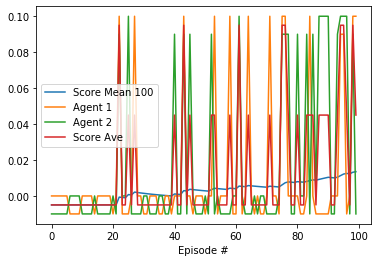

Episode 200(61sec)	 MIN:0.09 MAX:0.20 MEAN:0.15 MEANo100:0.05             
Episode 200	Average Score: 0.05


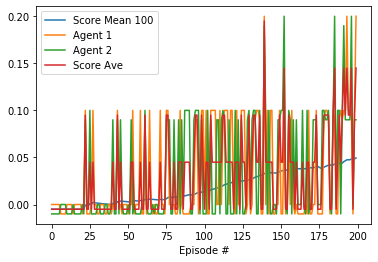

Episode 300(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.04           
Episode 300	Average Score: 0.04


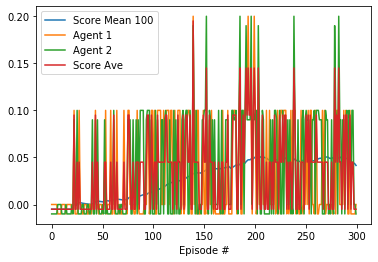

Episode 400(77sec)	 MIN:0.19 MAX:0.20 MEAN:0.20 MEANo100:0.04             
Episode 400	Average Score: 0.04


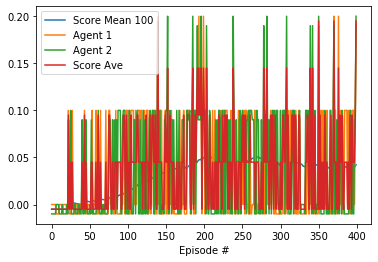

Episode 500(78sec)	 MIN:0.19 MAX:0.20 MEAN:0.20 MEANo100:0.04             
Episode 500	Average Score: 0.04


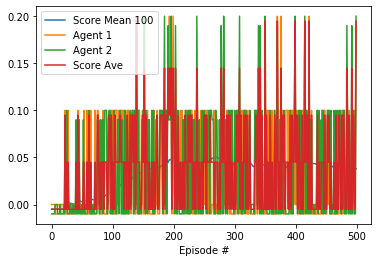

Episode 600(27sec)	 MIN:0.00 MAX:0.09 MEAN:0.05 MEANo100:0.04             
Episode 600	Average Score: 0.04


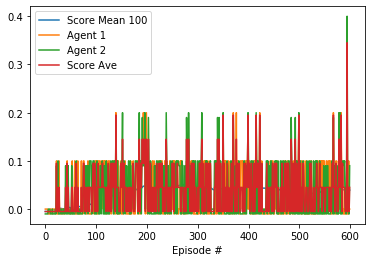

Episode 700(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.05           
Episode 700	Average Score: 0.05


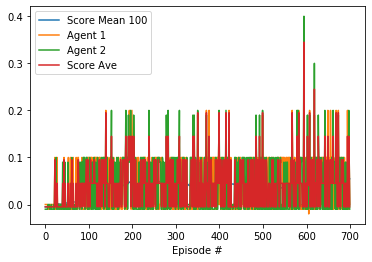

Episode 800(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.04           
Episode 800	Average Score: 0.04


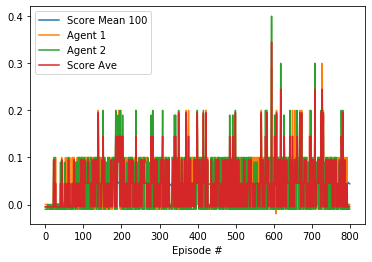

Episode 900(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.05           
Episode 900	Average Score: 0.05


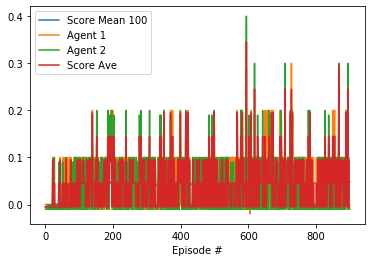

Episode 1000(45sec)	 MIN:0.09 MAX:0.10 MEAN:0.10 MEANo100:0.06            
Episode 1000	Average Score: 0.06


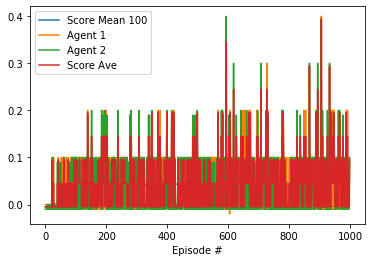

Episode 1100(27sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.05            
Episode 1100	Average Score: 0.05


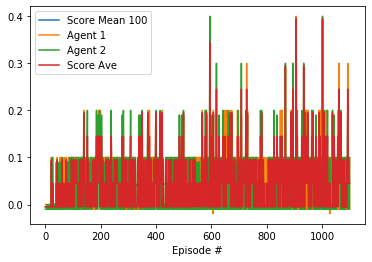

Episode 1150(79sec)	 MIN:0.19 MAX:0.20 MEAN:0.20 MEANo100:0.07             

In [ ]:
scores_ave, agent = train(n_episodes=2000, random_seed=0)

In [11]:
def play(play_agent, t=10, add_noise=False):
    # trained model
    # play times
    for i in range(t):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = np.reshape(env_info.vector_observations, (1,num_agents*state_size))
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        step = 0
        while True:
#             actions = play_agent.act(states, add_noise=False)                  # all actions between -1 and 1
            step += 1
            actions = [agent.act(states, add_noise) for agent in play_agent]
            actions = np.concatenate(actions, axis=0).flatten()
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size))
            rewards = env_info.rewards                         # get reward (for each agent)
#             print('step', step, 'rewards', rewards)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
#             time.sleep(0.5)
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (sum over agents) from episode {}: {:.2f}'.format(i, np.sum(scores)))

In [12]:
# read model weights
best_agent_0 = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents)
best_agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents)
actor_state_dict_0 = torch.load('./best_pth/1st/actor0.pth')
actor_state_dict_1 = torch.load('./best_pth/1st/actor1.pth')

best_agent_0.actor_local.load_state_dict(actor_state_dict_0)
best_agent_1.actor_local.load_state_dict(actor_state_dict_1)

play([best_agent_0, best_agent_1], t=10)

Score (sum over agents) from episode 0: 0.99
Score (sum over agents) from episode 1: 0.49
Score (sum over agents) from episode 2: 1.09
Score (sum over agents) from episode 3: 1.09
Score (sum over agents) from episode 4: 0.19
Score (sum over agents) from episode 5: 0.89
Score (sum over agents) from episode 6: 1.59
Score (sum over agents) from episode 7: 0.19
Score (sum over agents) from episode 8: 0.69
Score (sum over agents) from episode 9: 0.99


In [ ]:
env.close()